In [39]:
from alpha_vantage.timeseries import TimeSeries

from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from scipy.stats import shapiro, jarque_bera
from statsmodels.tsa.stattools import adfuller

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from torchinfo import summary
from torch.nn import TransformerEncoder, TransformerEncoderLayer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report

from tqdm import tqdm
import pickle

from plotly.subplots import make_subplots
import plotly.graph_objs as go

import math
import time

In [ ]:
# Original code from: https://www.kaggle.com/code/hobbyai/predict-stock-prices-using-pytorch-transformer/notebook
# we did the price prediction using the transformer model, and change the log-difference to the original price

In [40]:
def check_gpu():
    if torch.backends.mps.is_available():
        mps_device = torch.device("mps")
        x = torch.ones(1, device=mps_device)
        print(x)
    else:
        print ("MPS device not found.")
    return mps_device
device = check_gpu()

tensor([1.], device='mps:0')


In [41]:
data = pd.read_csv('NVDA.csv')
data.drop(['Open', 'High', 'Low', 'Adj Close'], axis=1, inplace=True)
data.head()

,Date,Close,Volume
0,2019-03-29,44.889999,45689600
1,2019-04-01,45.570000,48382400
2,2019-04-02,45.750000,44092000
3,2019-04-03,47.154999,78350400
4,2019-04-04,47.064999,45737600


In [42]:
data["log_price"] = np.log(data["Close"])
data.head()

,Date,Close,Volume,log_price
0,2019-03-29,44.889999,45689600,3.804215
1,2019-04-01,45.570000,48382400,3.819250
2,2019-04-02,45.750000,44092000,3.823192
3,2019-04-03,47.154999,78350400,3.853440
4,2019-04-04,47.064999,45737600,3.851530


In [43]:
data["diff_log_price"] = data["log_price"].diff()
data["diff_log_price"] = data["diff_log_price"].fillna(0)
data["cum_diff_log_price"] = data["diff_log_price"].cumsum()
data 

,Date,Close,Volume,log_price,diff_log_price,cum_diff_log_price
0,2019-03-29,44.889999,45689600,3.804215,0.000000,0.000000
1,2019-04-01,45.570000,48382400,3.819250,0.015035,0.015035
2,2019-04-02,45.750000,44092000,3.823192,0.003942,0.018977
3,2019-04-03,47.154999,78350400,3.853440,0.030248,0.049225
4,2019-04-04,47.064999,45737600,3.851530,-0.001910,0.047315
...,...,...,...,...,...,...
1254,2024-03-22,942.890015,58521500,6.848950,0.030736,3.044735
1255,2024-03-25,950.020020,55213600,6.856483,0.007533,3.052268
1256,2024-03-26,925.609985,51364800,6.830453,-0.026030,3.026238
1257,2024-03-27,902.500000,58606700,6.805169,-0.025284,3.000954


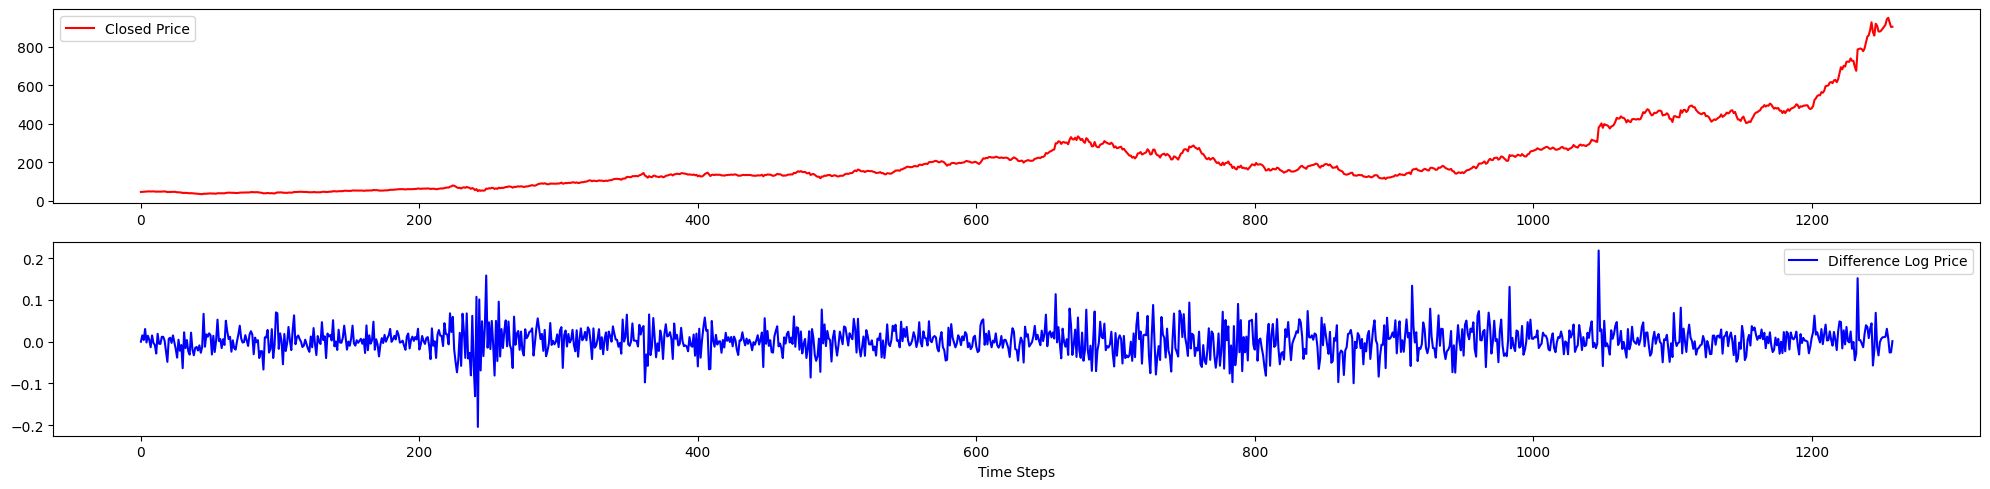

In [44]:
fig1, ax1 = plt.subplots(2, 1)
fig1.set_size_inches(20, 5)
ax1[0].plot(data["Close"], color='red')
ax1[1].plot(data["diff_log_price"], color='blue')
ax1[1].set_xlabel('Time Steps')

# set legend
ax1[0].legend(['Closed Price'])
ax1[1].legend(['Difference Log Price'])
fig1.tight_layout()

In [45]:
data_size = len(data)
data_train_size = data_size * 0.6
data_val_size = data_size * 0.2
data_test_size = data_size * 0.2
data_train_val = data[:int(data_train_size + data_val_size)]
data_train_test = pd.concat([data[:int(data_train_size)], data[int(data_train_size + data_val_size):]])
training = True
testing = False

In [46]:
if training:
    dataset = data_train_val.copy()
elif testing:
    dataset = data_train_test.copy()

In [47]:
input_window = 5 # number of input time steps
output_window = 1 # number of prediction steps (equals to one)
batch_size = 100

In [48]:
class PositionalEncoding(nn.Module):
    
    def __init__(self, d_model, dropout_p=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(dropout_p)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.dropout(x + self.pe[:x.size(0), :])

In [49]:
class Transformer(nn.Module):
    def __init__(self, feature_size=200, num_layers=2, dropout=0.1):
        # feautre_size equals to embedding dimension (d_model)
        super().__init__()
        self.model_type = 'Transformer'

        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        
        # Apply nhead multi-head attention
        # d_key, d_query, d_value = d_model // n_head
        self.encoder_layer = TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)
        
        # Use num_layers encoders
        self.transformer_encoder = TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        
        # For simple time-series prediction, decoder just uses FC layer
        self.decoder = nn.Linear(feature_size, 1)
        self._init_weights()

    def _init_weights(self):
        init_range = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-init_range, init_range)

    def forward(self, src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, size):
        mask = torch.tril(torch.ones(size, size) == 1) # Lower Triangular matrix
        mask = mask.float()
        mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
        mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0
        return mask

In [50]:
def create_inout_sequences(input_data, input_window):
    inout_seq = []
    L = len(input_data)
    for i in range(L - input_window):
        train_seq = input_data[i:i + input_window]
        train_label = input_data[i + output_window: i + input_window + output_window]
        inout_seq.append((train_seq, train_label))
    return torch.FloatTensor(inout_seq)

In [51]:
def get_data(data_raw, train_split=0.75,input_window=5, output_window=1):
    train_split = round(train_split * len(data_raw))
    
    train_data = data_raw[:train_split]
    validation_data = data_raw[train_split:]

    train_data = train_data.cumsum()
    train_data = 2 * train_data  # Training data scaling
    
    validation_data = validation_data.cumsum()
    
    train_sequence = create_inout_sequences(train_data, input_window)
    validation_sequence = create_inout_sequences(validation_data, input_window)
    
    validation_sequence = validation_sequence[:-output_window]
    train_sequence = train_sequence[:-output_window]

    return train_sequence.to(device), validation_sequence.to(device)

In [52]:
def get_batch(source, i, batch_size):
    seq_len = min(batch_size, len(source) - i)
    data = source[i:i+seq_len]
    data_in = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window, 1))
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window, 1))
    return data_in, target

def train(train_data):
    model.train() # Turn on the evaluation mode
    total_loss = 0.
    start_time = time.time()

    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch(train_data, i, batch_size)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 0.7)
        optimizer.step()

        total_loss = total_loss + loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.10f} | {:5.2f} ms | '
                  'loss {:5.7f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss))
            total_loss = 0
            start_time = time.time()

def evaluate(model, data_source):
    model.eval() # Turn on the evaluation mode
    total_loss = 0.
    eval_batch_size = 1000
    with torch.no_grad():
        for i in range(0, len(data_source) - 1, eval_batch_size):
            data, targets = get_batch(data_source, i, eval_batch_size)
            output = model(data)
            total_loss = total_loss + len(data[0]) * criterion(output, targets).cpu().item()
    return total_loss / len(data_source)

def predict(model, sequences):
    start_timer = time.time()
    model.eval()
    predicted_seq = torch.Tensor(0)
    real_seq = torch.Tensor(0)
    with torch.no_grad():
        for i in range(0, len(sequences)):
            data, target = get_batch(sequences, i, 1)
            output = model(data)
            predicted_seq = torch.cat((predicted_seq, output[-1].view(-1).cpu()), 0)
            real_seq = torch.cat((real_seq, target[-1].view(-1).cpu()), 0)
    timed = time.time() - start_timer
    print(f"{timed} sec")

    return predicted_seq, real_seq

In [53]:
train_data, validation_data = get_data(dataset["diff_log_price"].values, input_window=input_window, output_window=output_window)

In [54]:
model = Transformer().to(device)

criterion = nn.MSELoss() 
lr = 0.00005

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

N_EPOCHS = 300

/Users/vincentzhao/anaconda3/envs/deep_learning_finance/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)



In [55]:
for epoch in range(1, N_EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_data)
    if (epoch % N_EPOCHS == 0):  # Valid model after last training epoch
        val_loss = evaluate(model, validation_data)
        print('-' * 80)
        print('| end of epoch {:3d} | time: {:5.2f}s | valid loss: {:5.7f}'.format(epoch,
                                                                                   (time.time() - epoch_start_time),
                                                                                   val_loss))
        print('-' * 80)
    else:
        print('-' * 80)
        print('| end of epoch {:3d} | time: {:5.2f}s'.format(epoch, (time.time() - epoch_start_time)))
        print('-' * 80)
    scheduler.step()

/Users/vincentzhao/anaconda3/envs/deep_learning_finance/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:402: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch   1 |     1/    7 batches | lr 0.0000500000 | 83.84 ms | loss 0.7516630
| epoch   1 |     2/    7 batches | lr 0.0000500000 | 27.04 ms | loss 0.8474547
| epoch   1 |     3/    7 batches | lr 0.0000500000 | 27.77 ms | loss 1.5808159
| epoch   1 |     4/    7 batches | lr 0.0000500000 | 26.53 ms | loss 1.3192953
| epoch   1 |     5/    7 batches | lr 0.0000500000 | 27.08 ms | loss 1.2140648
| epoch   1 |     6/    7 batches | lr 0.0000500000 | 26.66 ms | loss 1.8687679
| epoch   1 |     7/    7 batches | lr 0.0000500000 | 26.64 ms | loss 0.7467788
--------------------------------------------------------------------------------
| end of epoch   1 | time:  0.25s
--------------------------------------------------------------------------------
| epoch   2 |     1/    7 batches | lr 0.0000451250 | 57.78 ms | loss 8.2523203
| epoch   2 |     2/    7 batches | lr 0.0000451250 | 29.05 ms | loss 6.4037499
| epoch   2 |     3/    7 batches | lr 0.0000451250 | 29.71 ms | loss 4.1725578
| ep

In [56]:
predicted_seq_val, real_seq_val = predict(model, validation_data)

0.8791899681091309 sec


MSE: 0.010328092612326145
RMSE: 0.10162722319364548


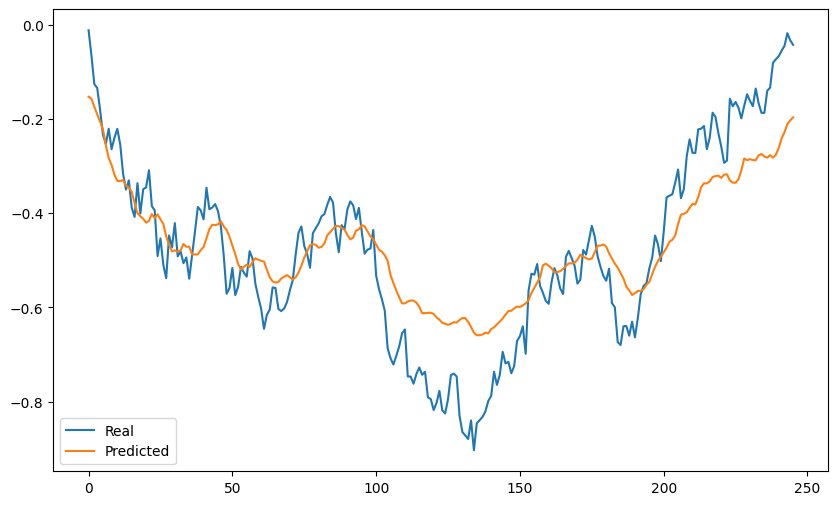

In [57]:
# calculate the mean squared error and the root mean squared error
mse = nn.MSELoss()
loss = mse(predicted_seq_val, real_seq_val)
print(f'MSE: {loss}')

loss = torch.sqrt(loss)
print(f'RMSE: {loss}')

# plot the predicted and real values
plt.figure(figsize=(10, 6))
plt.plot(real_seq_val, label='Real')
plt.plot(predicted_seq_val, label='Predicted')
plt.legend()
plt.show()

# Save the model
# torch.save(model.state_dict(), 'transformer_model.pth')

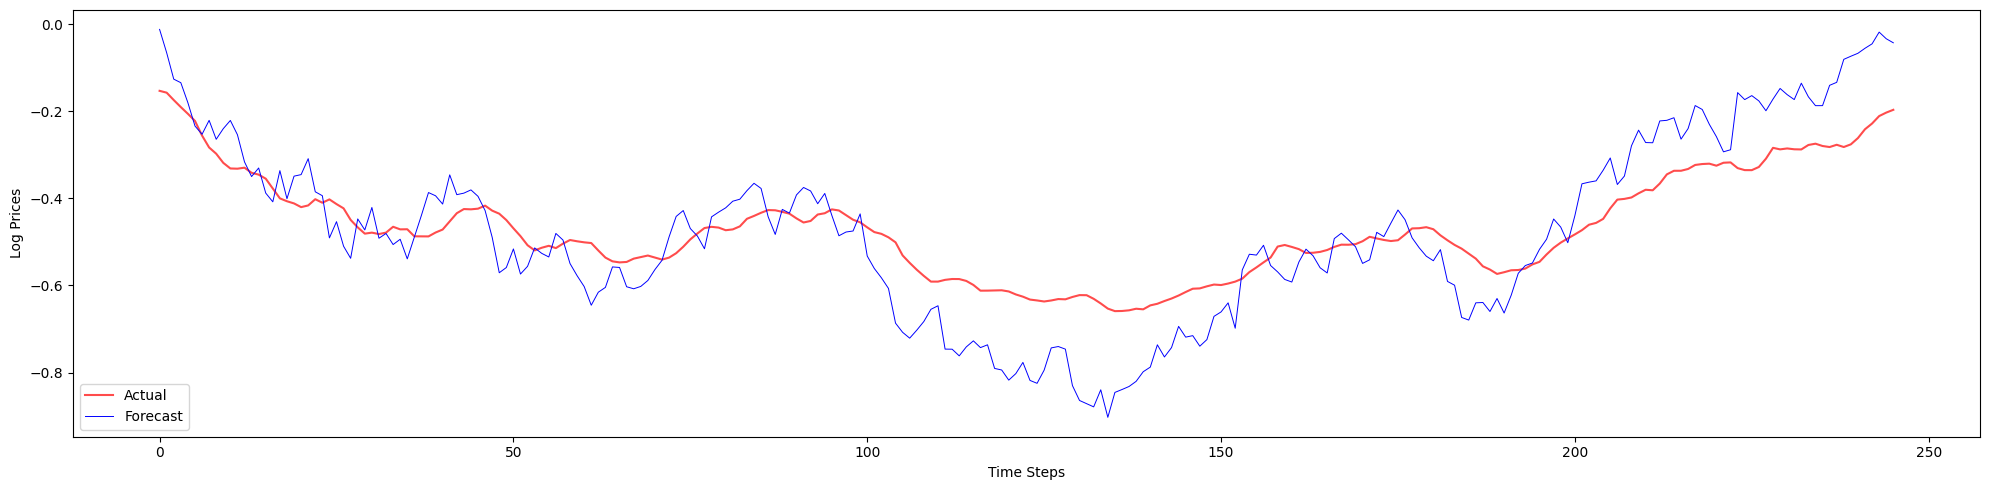

In [58]:

fig2, ax2 = plt.subplots(1, 1)

fig2.set_size_inches(20, 5)
ax2.plot(predicted_seq_val, color='red', alpha=0.7)
ax2.plot(real_seq_val, color='blue', linewidth=0.7)
ax2.legend(['Actual', 'Forecast'])
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Log Prices')

fig2.tight_layout()

In [59]:
end_train = round(0.75 * len(dataset))
start_val = end_train + input_window + 1
date_pred_val = dataset["Date"][start_val:]

predicted_seq_val_numpy = predicted_seq_val.numpy()
real_seq_val_numpy = real_seq_val.numpy()

In [60]:
# full_val_data = data[end_train+1:end_train+input_window+1]
full_val_data = dataset[end_train+1:].copy()

full_val_data.loc[:, "predicted_log_price"] = [0,0,0,0,0] + predicted_seq_val_numpy.tolist()
full_val_data.loc[:, "real_log_price"] = [0,0,0,0,0] + real_seq_val_numpy.tolist()

full_val_data["predicted_log_price"] = full_val_data["predicted_log_price"].shift(-1) 
full_val_data["real_log_price"] = full_val_data["real_log_price"].shift(-1)

full_val_data.loc[:, "tomorrow_price"] = np.exp(full_val_data["predicted_log_price"])

full_val_data.loc[:, "tomorrow_price"] = full_val_data["tomorrow_price"] + data["Close"]

full_val_data["predicted_price_today"] = full_val_data["tomorrow_price"].shift(1)

# Drop rows with NaN values.
full_val_data["Date"] = pd.to_datetime(full_val_data["Date"])
full_val_data.set_index("Date", inplace=True)

In [61]:
# mase
rmse = np.sqrt(np.mean((full_val_data["Close"] - full_val_data["predicted_price_today"])**2))
mase = rmse / np.mean(np.abs(full_val_data["Close"].diff()))
print(f'MASE: {mase}')
print(f'RMSE: {rmse}')

MASE: 1.2853613265748431
RMSE: 6.900334712176106


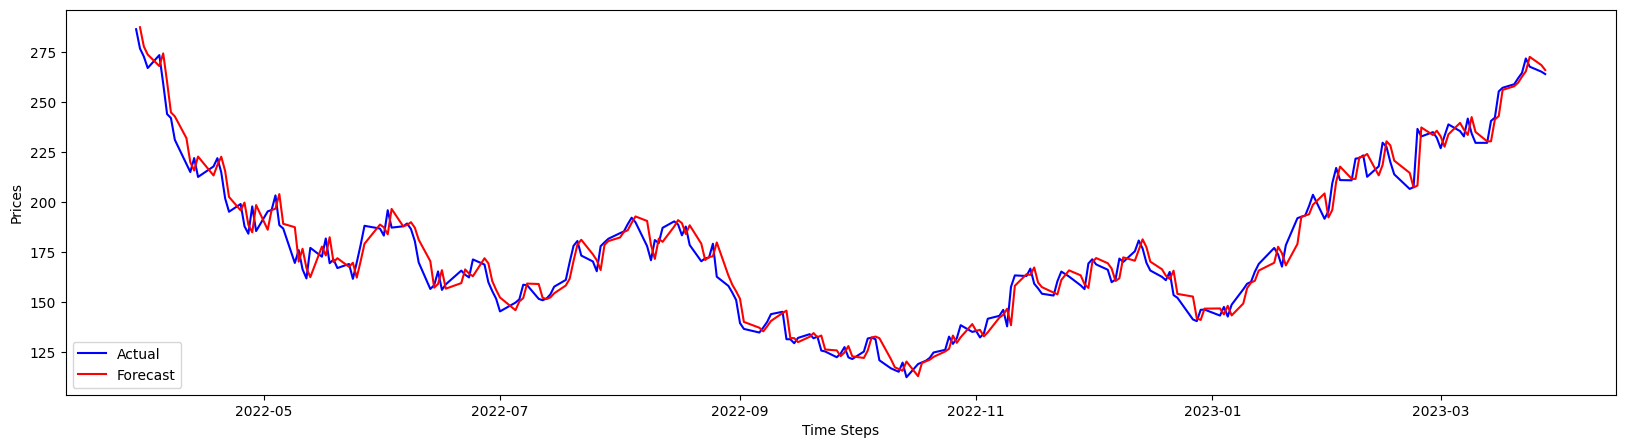

In [62]:
plt.figure(figsize=(20, 5))
plt.plot(full_val_data.index,full_val_data["Close"], color='blue')
plt.plot(full_val_data.index,full_val_data["predicted_price_today"], color='red')
plt.legend(['Actual', 'Forecast'])
plt.xlabel('Time Steps')
plt.ylabel('Prices')
plt.show()

In [63]:
mean_squared_error = ((full_val_data["Close"] - full_val_data["predicted_price_today"]) ** 2).mean()
root_mean_squared_error = np.sqrt(mean_squared_error)
print(f'MSE: {mean_squared_error}')
print(f'RMSE: {root_mean_squared_error}')

MSE: 47.6146191400625
RMSE: 6.900334712176106


In [64]:
if training:
    full_val_data.to_csv("final_result_Transformer_validation.csv")
if testing:
    full_val_data.to_csv("Transformer_for_stock.csv")

In [65]:
final_result_Transformer_validation = pd.read_csv("final_result_Transformer_validation.csv")
Transformer_for_stock = pd.read_csv("Transformer_for_stock.csv")

In [66]:
final_result_Transformer_validation

,Date,Close,Volume,log_price,diff_log_price,cum_diff_log_price,predicted_log_price,real_log_price,tomorrow_price,predicted_price_today
0,2022-03-29,286.559998,48898400,5.657948,0.015367,1.853733,0.000000,0.000000,287.559998,NaN
1,2022-03-30,276.899994,46348700,5.623656,-0.034292,1.819441,0.000000,0.000000,277.899994,287.559998
2,2022-03-31,272.859985,52344000,5.608959,-0.014698,1.804744,0.000000,0.000000,273.859985,277.899994
3,2022-04-01,267.119995,51723500,5.587698,-0.021261,1.783483,0.000000,0.000000,268.119995,273.859985
4,2022-04-04,273.600006,39712000,5.611667,0.023969,1.807452,-0.153134,-0.012061,274.458020,268.119995
...,...,...,...,...,...,...,...,...,...,...
246,2023-03-22,264.679993,79729500,5.578522,0.010215,1.774306,-0.228175,-0.045207,265.475978,262.775583
247,2023-03-23,271.910004,56488900,5.605471,0.026950,1.801256,-0.211092,-0.018258,272.719704,265.475978
248,2023-03-24,267.790009,45492000,5.590203,-0.015268,1.785988,-0.203101,-0.033526,268.606204,272.719704
249,2023-03-27,265.309998,36102600,5.580899,-0.009304,1.776684,-0.196717,-0.042830,266.131421,268.606204


In [67]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Scatter(x=final_result_Transformer_validation["Date"], y=final_result_Transformer_validation["Close"], mode='lines', name='Close Price (Validation)'), row=1, col=1)
fig.add_trace(go.Scatter(x=final_result_Transformer_validation["Date"], y=final_result_Transformer_validation["predicted_price_today"], mode='lines', name='5-days ahead Close Price Prediction (Validation)'), row=1, col=1)

fig.add_trace(go.Scatter(x=Transformer_for_stock["Date"], y=Transformer_for_stock["Close"], mode='lines', name='Close Price (Test)'), row=2, col=1)
fig.add_trace(go.Scatter(x=Transformer_for_stock["Date"], y=Transformer_for_stock["predicted_price_today"], mode='lines', name='5-days ahead Close Price Prediction (Test)'), row=2, col=1)

fig.update_yaxes(title_text="Close Price ($)", row=1, col=1)
fig.update_yaxes(title_text="Close Price ($)", row=2, col=1)

fig.update_layout(height=600)

fig.show()

In [68]:
full_val_data

,Close,Volume,log_price,diff_log_price,cum_diff_log_price,predicted_log_price,real_log_price,tomorrow_price,predicted_price_today
Date,,,,,,,,,
2022-03-29,286.559998,48898400,5.657948,0.015367,1.853733,0.000000,0.000000,287.559998,NaN
2022-03-30,276.899994,46348700,5.623656,-0.034292,1.819441,0.000000,0.000000,277.899994,287.559998
2022-03-31,272.859985,52344000,5.608959,-0.014698,1.804744,0.000000,0.000000,273.859985,277.899994
2022-04-01,267.119995,51723500,5.587698,-0.021261,1.783483,0.000000,0.000000,268.119995,273.859985
2022-04-04,273.600006,39712000,5.611667,0.023969,1.807452,-0.153134,-0.012061,274.458020,268.119995
...,...,...,...,...,...,...,...,...,...
2023-03-22,264.679993,79729500,5.578522,0.010215,1.774306,-0.228175,-0.045207,265.475978,262.775583
2023-03-23,271.910004,56488900,5.605471,0.026950,1.801256,-0.211092,-0.018258,272.719704,265.475978
2023-03-24,267.790009,45492000,5.590203,-0.015268,1.785988,-0.203101,-0.033526,268.606204,272.719704
